In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim    
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
import numpy
from PIL import Image
from pylab import *
from skimage.feature import hog
from skimage import feature
from sklearn import datasets
import cv2
from skimage import exposure
import timeit
from skimage import transform as tf
from scipy import ndimage
from sklearn.decomposition import PCA
from scipy import fftpack

In [2]:
#Multi-Layer Perceptron Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
        

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

MLP_network = MLP()

In [3]:
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(MLP_network.parameters(), lr=0.001, betas=(0.9,0.99), eps=1e-08, weight_decay=0.001)  

In [4]:
# transforms to apply to the mnist data
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=trans)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=trans)
classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

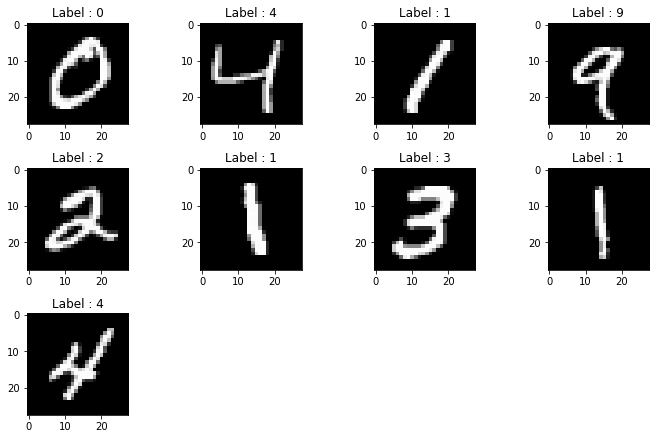

In [5]:
fig = plt.figure(figsize=(10,10));
columns = 4;
rows = 5;
for i in range(1, 10):
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.imshow(train_dataset.train_data[i].numpy(), cmap='gray')
    plt.title('Label : %i' % train_dataset.train_labels[i])
plt.show()

In [6]:
#Spectral Processing of the Dataset
pca = PCA(0.95)
train_dataset.train_data = train_dataset.train_data.type(torch.FloatTensor)
test_dataset.test_data = test_dataset.test_data.type(torch.FloatTensor)

for i in range(0,len(train_dataset)):
    pca_im = pca.fit_transform(train_dataset.train_data[i].numpy())
    image = pca.inverse_transform(pca_im)
    train_dataset.train_data[i] = torch.from_numpy(image)
    
for i in range(0,len(test_dataset)):
    pca_im = pca.fit_transform(test_dataset.test_data[i].numpy())
    image = pca.inverse_transform(pca_im)
    test_dataset.test_data[i] = torch.from_numpy(image)

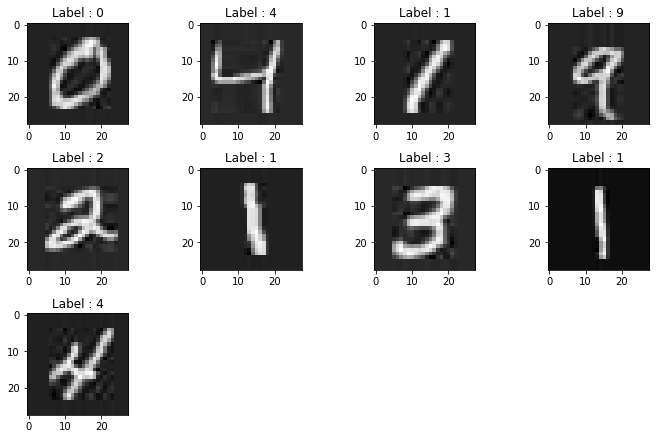

In [7]:
fig = plt.figure(figsize=(10,10));
columns = 4;
rows = 5;
for i in range(1, 10):
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.imshow(train_dataset.train_data[i].numpy(), cmap='gray')
    plt.title('Label : %i' % train_dataset.train_labels[i])
plt.show()

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10, shuffle=False, num_workers=2)

In [9]:
num_epochs = 20
total_step = len(train_loader)
Loss = []
print('----------------------------------------------------')
start= timeit.default_timer()
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = MLP_network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('Epoch {}  | Loss : {:.4f}'.format(epoch+1, running_loss / total_step))        
    print('----------------------------------------------------')
    Loss.append(running_loss / total_step)
print('Finished Training')
stop = timeit.default_timer()

----------------------------------------------------
Epoch 1  | Loss : 1.4599
----------------------------------------------------
Epoch 2  | Loss : 1.3033
----------------------------------------------------
Epoch 3  | Loss : 1.2554
----------------------------------------------------
Epoch 4  | Loss : 1.2237
----------------------------------------------------
Epoch 5  | Loss : 1.2011
----------------------------------------------------
Epoch 6  | Loss : 1.1857
----------------------------------------------------
Epoch 7  | Loss : 1.1724
----------------------------------------------------
Epoch 8  | Loss : 1.1589
----------------------------------------------------
Epoch 9  | Loss : 1.1500
----------------------------------------------------
Epoch 10  | Loss : 1.1399
----------------------------------------------------
Epoch 11  | Loss : 1.1360
----------------------------------------------------
Epoch 12  | Loss : 1.1302
----------------------------------------------------
Epoch 13

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = MLP_network(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the Test images: %d %%' % (100 * correct / total))

Accuracy of the network on the Test images: 58 %


In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = MLP_network(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of class %s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of class 0 : 54 %
Accuracy of class 1 : 86 %
Accuracy of class 2 : 64 %
Accuracy of class 3 : 44 %
Accuracy of class 4 : 60 %
Accuracy of class 5 : 56 %
Accuracy of class 6 : 80 %
Accuracy of class 7 : 61 %
Accuracy of class 8 : 29 %
Accuracy of class 9 : 44 %


In [12]:
#Applying Different Feature extraction Methods
##SOBEL EDGE Detector##
train_sobel = train_dataset
test_sobel = test_dataset
for i in range(0,len(train_sobel)):
    image = ndimage.sobel(train_sobel.train_data[i].numpy()) 
    train_sobel.train_data[i] = torch.from_numpy(image)
    
for i in range(0,len(test_sobel)):
    image = ndimage.sobel(test_sobel.test_data[i].numpy()) 
    test_sobel.test_data[i] = torch.from_numpy(image)   

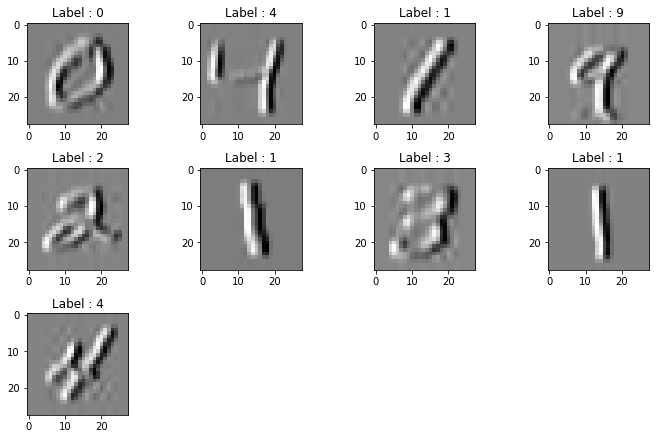

In [13]:
fig = plt.figure(figsize=(10,10));
columns = 4;
rows = 5;
for i in range(1, 10):
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.imshow(train_sobel.train_data[i].numpy(), cmap='gray')
    plt.title('Label : %i' % train_sobel.train_labels[i])
plt.show()

In [14]:
train_sobel_loader = torch.utils.data.DataLoader(train_sobel, batch_size=10, shuffle=True, num_workers=2)
test_sobel_loader = torch.utils.data.DataLoader(dataset=test_sobel, batch_size=10, shuffle=False, num_workers=2)

In [15]:
num_epochs = 20
total_step = len(train_sobel_loader)
Loss_1 = []
print('----------------------------------------------------')
start1 = timeit.default_timer()
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_sobel_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = MLP_network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('Epoch {}  | Loss : {:.4f}'.format(epoch+1, running_loss / total_step))        
    print('----------------------------------------------------')
    Loss_1.append(running_loss / total_step)
print('Finished Training')
stop1 = timeit.default_timer()

----------------------------------------------------
Epoch 1  | Loss : 1.5290
----------------------------------------------------
Epoch 2  | Loss : 1.3266
----------------------------------------------------
Epoch 3  | Loss : 1.2670
----------------------------------------------------
Epoch 4  | Loss : 1.2338
----------------------------------------------------
Epoch 5  | Loss : 1.2160
----------------------------------------------------
Epoch 6  | Loss : 1.2034
----------------------------------------------------
Epoch 7  | Loss : 1.1909
----------------------------------------------------
Epoch 8  | Loss : 1.1832
----------------------------------------------------
Epoch 9  | Loss : 1.1768
----------------------------------------------------
Epoch 10  | Loss : 1.1751
----------------------------------------------------
Epoch 11  | Loss : 1.1694
----------------------------------------------------
Epoch 12  | Loss : 1.1690
----------------------------------------------------
Epoch 13

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_sobel_loader:
        images, labels = data
        outputs = MLP_network(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the Test images: %d %%' % (100 * correct / total))

Accuracy of the network on the Test images: 55 %


In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_sobel_loader:
        images, labels = data
        outputs = MLP_network(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of class %s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of class 0 : 55 %
Accuracy of class 1 : 86 %
Accuracy of class 2 : 57 %
Accuracy of class 3 : 58 %
Accuracy of class 4 : 63 %
Accuracy of class 5 : 39 %
Accuracy of class 6 : 68 %
Accuracy of class 7 : 43 %
Accuracy of class 8 : 16 %
Accuracy of class 9 : 62 %


In [18]:
##CANNY EDGE DETECTOR##
train_canny  = train_dataset
test_canny = test_dataset

for i in range(0,len(train_canny)):
    image = feature.canny(train_canny.train_data[i].numpy()) * 1
    train_canny.train_data[i] = torch.from_numpy(image)
    
for i in range(0,len(test_canny)):
    image = feature.canny(test_canny.test_data[i].numpy()) * 1
    test_canny.test_data[i] = torch.from_numpy(image)

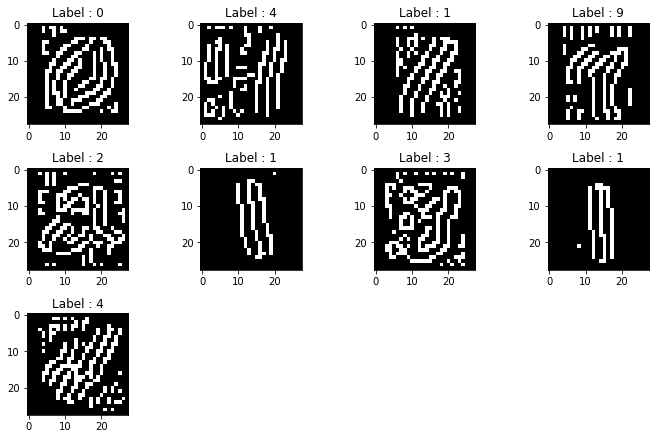

In [19]:
fig = plt.figure(figsize=(10,10));
columns = 4;
rows = 5;
for i in range(1, 10):
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.imshow(train_canny.train_data[i].numpy(), cmap='gray')
    plt.title('Label : %i' % train_canny.train_labels[i])
plt.show()

In [20]:
train_canny_loader = torch.utils.data.DataLoader(train_canny, batch_size=10, shuffle=True, num_workers=2)
test_canny_loader = torch.utils.data.DataLoader(dataset=test_canny, batch_size=10, shuffle=False, num_workers=2)

In [21]:
num_epochs = 20
total_step = len(train_canny_loader)
Loss_2 = []
print('----------------------------------------------------')
start2 = timeit.default_timer()
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_canny_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = MLP_network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('Epoch {}  | Loss : {:.4f}'.format(epoch+1, running_loss / total_step))        
    print('----------------------------------------------------')
    Loss_2.append(running_loss / total_step)
print('Finished Training')
stop2 = timeit.default_timer()

----------------------------------------------------
Epoch 1  | Loss : 1.3582
----------------------------------------------------
Epoch 2  | Loss : 1.1699
----------------------------------------------------
Epoch 3  | Loss : 1.1127
----------------------------------------------------
Epoch 4  | Loss : 1.0740
----------------------------------------------------
Epoch 5  | Loss : 1.0489
----------------------------------------------------
Epoch 6  | Loss : 1.0315
----------------------------------------------------
Epoch 7  | Loss : 1.0192
----------------------------------------------------
Epoch 8  | Loss : 1.0132
----------------------------------------------------
Epoch 9  | Loss : 1.0062
----------------------------------------------------
Epoch 10  | Loss : 1.0032
----------------------------------------------------
Epoch 11  | Loss : 0.9991
----------------------------------------------------
Epoch 12  | Loss : 0.9933
----------------------------------------------------
Epoch 13

In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_canny_loader:
        images, labels = data
        outputs = MLP_network(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the Test images: %d %%' % (100 * correct / total))

Accuracy of the network on the Test images: 64 %


In [23]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_canny_loader:
        images, labels = data
        outputs = MLP_network(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of class %s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of class 0 : 35 %
Accuracy of class 1 : 95 %
Accuracy of class 2 : 60 %
Accuracy of class 3 : 56 %
Accuracy of class 4 : 73 %
Accuracy of class 5 : 64 %
Accuracy of class 6 : 85 %
Accuracy of class 7 : 69 %
Accuracy of class 8 : 51 %
Accuracy of class 9 : 52 %


In [24]:
##LOCAL BINARY PATTERN##
train_lbp = train_dataset
test_lbp = test_dataset

for i in range(0,len(train_lbp)):
    image = feature.local_binary_pattern(train_lbp.train_data[i].numpy(), P = 100, R = 50)
    train_lbp.train_data[i] = torch.from_numpy(image)
    
for i in range(0,len(test_lbp)):
    image = feature.local_binary_pattern(test_lbp.test_data[i].numpy(), P = 100, R = 50)
    test_lbp.test_data[i] = torch.from_numpy(image)

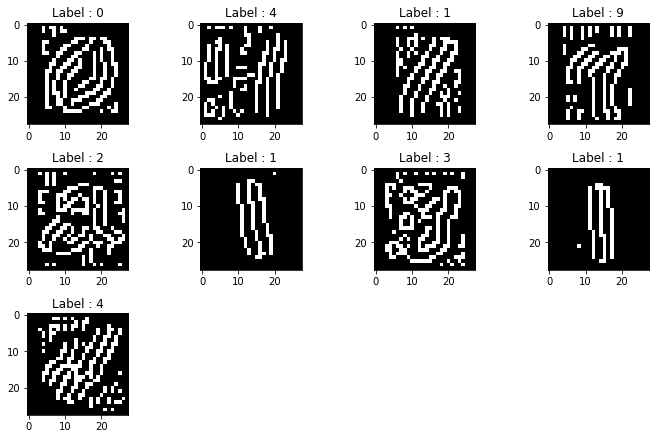

In [25]:
fig = plt.figure(figsize=(10,10));
columns = 4;
rows = 5;
for i in range(1, 10):
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.imshow(train_lbp.train_data[i].numpy(), cmap='gray')
    plt.title('Label : %i' % train_lbp.train_labels[i])
plt.show()

In [26]:
train_lbp_loader = torch.utils.data.DataLoader(train_lbp, batch_size=10, shuffle=True, num_workers=2)
test_lbp_loader = torch.utils.data.DataLoader(dataset=test_lbp, batch_size=10, shuffle=False, num_workers=2)

In [27]:
num_epochs = 20
total_step = len(train_lbp_loader)
Loss_3 = []
print('----------------------------------------------------')
start3 = timeit.default_timer()
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_lbp_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = MLP_network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('Epoch {}  | Loss : {:.4f}'.format(epoch+1, running_loss / total_step))        
    print('----------------------------------------------------')
    Loss_3.append(running_loss / total_step)
print('Finished Training')
stop3 = timeit.default_timer()

----------------------------------------------------
Epoch 1  | Loss : 1.3584
----------------------------------------------------
Epoch 2  | Loss : 1.1537
----------------------------------------------------
Epoch 3  | Loss : 1.1160
----------------------------------------------------
Epoch 4  | Loss : 1.0978
----------------------------------------------------
Epoch 5  | Loss : 1.0856
----------------------------------------------------
Epoch 6  | Loss : 1.0760
----------------------------------------------------
Epoch 7  | Loss : 1.0677
----------------------------------------------------
Epoch 8  | Loss : 1.0586
----------------------------------------------------
Epoch 9  | Loss : 1.0524
----------------------------------------------------
Epoch 10  | Loss : 1.0501
----------------------------------------------------
Epoch 11  | Loss : 1.0463
----------------------------------------------------
Epoch 12  | Loss : 1.0414
----------------------------------------------------
Epoch 13

In [28]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_lbp_loader:
        images, labels = data
        outputs = MLP_network(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the Test images: %d %%' % (100 * correct / total))

Accuracy of the network on the Test images: 64 %


In [29]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_lbp_loader:
        images, labels = data
        outputs = MLP_network(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of class %s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of class 0 : 54 %
Accuracy of class 1 : 89 %
Accuracy of class 2 : 53 %
Accuracy of class 3 : 74 %
Accuracy of class 4 : 58 %
Accuracy of class 5 : 52 %
Accuracy of class 6 : 84 %
Accuracy of class 7 : 77 %
Accuracy of class 8 : 34 %
Accuracy of class 9 : 55 %


In [30]:
##PEAK LOCAL MAXIMA##
train_plm = train_dataset
test_plm = test_dataset

for i in range(0,len(train_plm)):
    image = feature.peak_local_max(train_plm.train_data[i].numpy(), indices = False) * 1
    train_plm.train_data[i] = torch.from_numpy(image)
    
for i in range(0,len(test_plm)):
    image = feature.peak_local_max(test_plm.test_data[i].numpy(), indices = False) * 1
    test_plm.test_data[i] = torch.from_numpy(image)

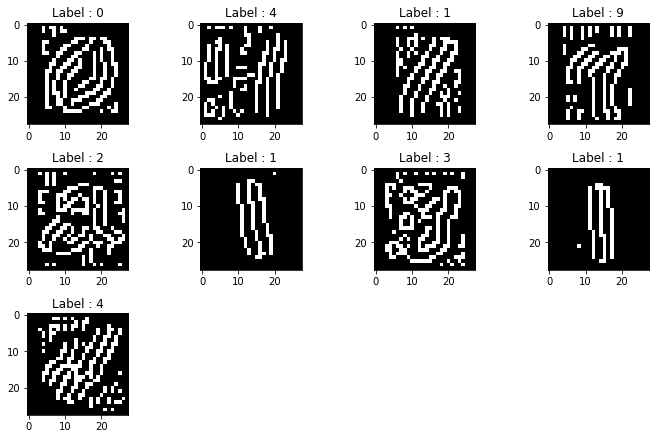

In [31]:
fig = plt.figure(figsize=(10,10));
columns = 4;
rows = 5;
for i in range(1, 10):
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.imshow(train_plm.train_data[i].numpy(), cmap='gray')
    plt.title('Label : %i' % train_plm.train_labels[i])
plt.show()

In [32]:
train_plm_loader = torch.utils.data.DataLoader(train_plm, batch_size=10, shuffle=True, num_workers=2)
test_plm_loader = torch.utils.data.DataLoader(dataset=test_plm, batch_size=10, shuffle=False, num_workers=2)

In [33]:
num_epochs = 20
total_step = len(train_plm_loader)
Loss_4 = []
print('----------------------------------------------------')
start4 = timeit.default_timer()
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_plm_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = MLP_network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('Epoch {}  | Loss : {:.4f}'.format(epoch+1, running_loss / total_step))        
    print('----------------------------------------------------')
    Loss_4.append(running_loss / total_step)
print('Finished Training')
stop4 = timeit.default_timer()

----------------------------------------------------
Epoch 1  | Loss : 1.2175
----------------------------------------------------
Epoch 2  | Loss : 1.0957
----------------------------------------------------
Epoch 3  | Loss : 1.0621
----------------------------------------------------
Epoch 4  | Loss : 1.0402
----------------------------------------------------
Epoch 5  | Loss : 1.0289
----------------------------------------------------
Epoch 6  | Loss : 1.0196
----------------------------------------------------
Epoch 7  | Loss : 1.0152
----------------------------------------------------
Epoch 8  | Loss : 1.0104
----------------------------------------------------
Epoch 9  | Loss : 1.0083
----------------------------------------------------
Epoch 10  | Loss : 1.0040
----------------------------------------------------
Epoch 11  | Loss : 1.0034
----------------------------------------------------
Epoch 12  | Loss : 0.9995
----------------------------------------------------
Epoch 13

In [34]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_plm_loader:
        images, labels = data
        outputs = MLP_network(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the Test images: %d %%' % (100 * correct / total))

Accuracy of the network on the Test images: 63 %


In [35]:
classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_plm_loader:
        images, labels = data
        outputs = MLP_network(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of class %s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of class 0 : 49 %
Accuracy of class 1 : 93 %
Accuracy of class 2 : 61 %
Accuracy of class 3 : 51 %
Accuracy of class 4 : 45 %
Accuracy of class 5 : 49 %
Accuracy of class 6 : 88 %
Accuracy of class 7 : 70 %
Accuracy of class 8 : 58 %
Accuracy of class 9 : 65 %


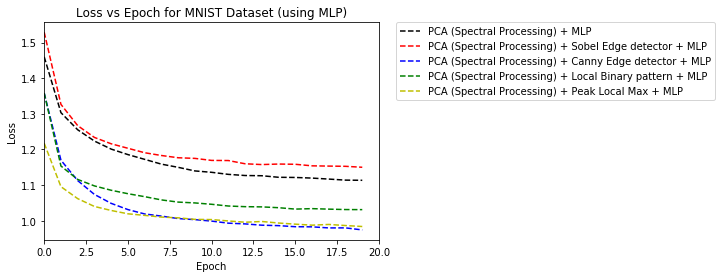

In [36]:
plt.plot(Loss, 'k--', label = "PCA (Spectral Processing) + MLP")
plt.plot(Loss_1, 'r--', label = "PCA (Spectral Processing) + Sobel Edge detector + MLP")
plt.plot(Loss_2, 'b--', label = "PCA (Spectral Processing) + Canny Edge detector + MLP")
plt.plot(Loss_3, 'g--', label = "PCA (Spectral Processing) + Local Binary pattern + MLP")
plt.plot(Loss_4, 'y--', label = "PCA (Spectral Processing) + Peak Local Max + MLP")
plt.title("Loss vs Epoch for MNIST Dataset (using MLP)")
plt.xlim([0, num_epochs])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [37]:
print("Computation time for classifying the data for PCA (Spectral Processing) + MLP : %f minutes" %((stop-start)/60))
print("Computation time for classifying the data for PCA (Spectral Processing) + Sobel Edge detector + MLP : %f minutes" %((stop1-start1)/60))
print("Computation time for classifying the data for PCA (Spectral Processing) + Canny Edge detector + MLP : %f minutes" %((stop2-start2)/60))
print("Computation time for classifying the data for PCA (Spectral Processing) + Local Binary pattern + MLP : %f minutes" %((stop3-start3)/60))
print("Computation time for classifying the data for PCA (Spectral Processing) + Peak Local Max + MLP : %f minutes" %((stop4-start4)/60))

Computation time for classifying the data for PCA (Spectral Processing) + MLP : 12.213615 minutes
Computation time for classifying the data for PCA (Spectral Processing) + Sobel Edge detector + MLP : 11.371910 minutes
Computation time for classifying the data for PCA (Spectral Processing) + Canny Edge detector + MLP : 12.386973 minutes
Computation time for classifying the data for PCA (Spectral Processing) + Local Binary pattern + MLP : 11.084975 minutes
Computation time for classifying the data for PCA (Spectral Processing) + Peak Local Max + MLP : 11.127522 minutes
